#  Learning Objectives


By the end of this tutorial, you will be able to:

-  Run SimBa to retrieve similar fact-checked claims for any input sentence
-  Interpret SimBa's output and similarity scores
-  Customize retrieval and reranking settings
-  Plot and analyze the distribution of similarity scores


##  Target Audience


This tutorial is aimed at **beginners with some knowledge of Python** and basic familiarity with terminal commands or Jupyter Notebooks.


##  Setting up the Computational Environment


The following Python packages are required:

```bash
pip install pandas matplotlib nltk
```

You must also install packages listed in SimBa’s `requirements.txt`:

```bash
pip install -r ../requirements.txt
```


##  Duration

Estimated time to complete this tutorial: **20–30 minutes**

##  Social Science Use Case(s)


SimBa has been used in research to support:

- Analysis of misinformation spread in online discourse
- Retrieval of fact-checked claims from large knowledge bases
- Fact-check support for journalistic and academic workflows

> For example, SimBa was evaluated in the CLEF CheckThat! Lab to detect previously verified claims ([Hövelmeyer et al., 2022](https://ceur-ws.org/Vol-3180/paper-40.pdf)).


#  SimBa Tutorial: Retrieve Fact-Checks for Your Claims


This Jupyter notebook walks you through how to use **SimBa** to retrieve fact-checked claims similar to a query.
We'll:
- Prepare a query
- Run SimBa with and without cache
- Load and inspect the results
- Plot similarity scores


# Set the working directory to SimBa's directory

# Modified run function that works from SimBa directory

# Add SimBa to Python path

In [15]:
import sys
sys.path.append("H:/detection-of-verified-claims")
import main

# First, let's check if the required files exist

In [16]:
import sys
import os
import subprocess

# Add SimBa to path and change to its directory
simba_dir = "H:/detection-of-verified-claims"
sys.path.append(simba_dir)
os.chdir(simba_dir)
print(f"Changed working directory to: {os.getcwd()}")

# Check SimBa structure
def check_simba_structure():
    required_files = [
        "src/candidate_retrieval/retrieval.py",
        "src/re_ranking/re_ranking.py",
        "data/claimsKG/corpus.tsv"
    ]
    
    print("Checking SimBa structure:")
    for file_path in required_files:
        exists = os.path.exists(file_path)
        print(f"  {'✓' if exists else '✗'} {file_path}: {exists}")
    
    return all(os.path.exists(f) for f in required_files)

# Check structure
structure_ok = check_simba_structure()

# Create queries file if needed
queries_file = "data/mydata/queries.tsv"
print(f"\nQueries file: {queries_file} - {'✓' if os.path.exists(queries_file) else '✗'}")

if not os.path.exists(queries_file):
    print("Creating queries file in SimBa directory...")
    os.makedirs("data/mydata", exist_ok=True)
    query = "Dog-owners face 78% higher risk of catching Covid-19"
    with open(queries_file, "w", encoding="utf-8") as f:
        f.write("1\t" + query + "\n")
    print("✓ Queries file created")

# Function to run SimBa with debug output
def run_simba_fixed(dataset_name, database_name="claimsKG", use_cache=False):
    print(f"\n🔍 Running SimBa from correct directory...")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Dataset: {dataset_name}")
    print(f"Database: {database_name}")
    print(f"Use cache: {use_cache}")
    
    # Input files (relative to SimBa directory)
    data_name_queries = f"data/{dataset_name}/queries.tsv"
    data_name_targets = f"data/{database_name}/corpus.tsv"
    
    print(f"\nInput files:")
    print(f"  Queries: {data_name_queries} - {'✓' if os.path.exists(data_name_queries) else '✗'}")
    print(f"  Targets: {data_name_targets} - {'✓' if os.path.exists(data_name_targets) else '✗'}")
    
    if not os.path.exists(data_name_queries):
        print("❌ Queries file not found!")
        return
    
    if not os.path.exists(data_name_targets):
        print("❌ Claims database not found!")
        return
    
    # Clear cache if requested
    if not use_cache:
        caching_directory = os.path.join("data", "cache", dataset_name)
        if os.path.exists(caching_directory):
            import shutil
            shutil.rmtree(caching_directory)
            print(f"🗑️ Cleared cache: {caching_directory}")
    
    # Run candidate retrieval
    retrieval_command = [
        "python",
        "src/candidate_retrieval/retrieval.py",
        data_name_queries,
        data_name_targets,
        dataset_name,
        dataset_name,
        "braycurtis",
        "50",
        "-sentence_embedding_models", "all-mpnet-base-v2"
    ]
    
    print(f"\n🔄 Running candidate retrieval...")
    print(f"Command: {' '.join(retrieval_command)}")
    
    try:
        result = subprocess.run(retrieval_command, capture_output=True, text=True)
        print(f"Return code: {result.returncode}")
        
        if result.stdout:
            print("STDOUT:")
            print(result.stdout)
        
        if result.stderr:
            print("STDERR:")
            print(result.stderr)
        
        if result.returncode != 0:
            print("❌ Candidate retrieval failed!")
            return
        else:
            print("✓ Candidate retrieval completed")
            
    except Exception as e:
        print(f"❌ Error running candidate retrieval: {e}")
        return
    
    # Run re-ranking
    reranking_command = [
        "python",
        "src/re_ranking/re_ranking.py",
        data_name_queries,
        data_name_targets,
        dataset_name,
        dataset_name,
        "braycurtis",
        "5",
        "-sentence_embedding_models",
        "all-mpnet-base-v2",
        "sentence-transformers/sentence-t5-base",
        "princeton-nlp/unsup-simcse-roberta-base",
        "-lexical_similarity_measures", "similar_words_ratio"
    ]
    
    print(f"\n🔄 Running re-ranking...")
    print(f"Command: {' '.join(reranking_command)}")
    
    try:
        result = subprocess.run(reranking_command, capture_output=True, text=True)
        print(f"Return code: {result.returncode}")
        
        if result.stdout:
            print("STDOUT:")
            print(result.stdout)
        
        if result.stderr:
            print("STDERR:")
            print(result.stderr)
        
        if result.returncode != 0:
            print("❌ Re-ranking failed!")
            return
        else:
            print("✓ Re-ranking completed")
            
    except Exception as e:
        print(f"❌ Error running re-ranking: {e}")
        return
    
    # Check what files were created
    print(f"\n📁 Files in data/{dataset_name}:")
    output_dir = f"data/{dataset_name}"
    if os.path.exists(output_dir):
        for file in os.listdir(output_dir):
            file_path = os.path.join(output_dir, file)
            size = os.path.getsize(file_path)
            print(f"  {file} ({size} bytes)")
    else:
        print(f"  Directory {output_dir} not found!")

# Actually run SimBa
if structure_ok:
    run_simba_fixed("mydata", "claimsKG", use_cache=False)
else:
    print("\n❌ Cannot run SimBa - missing required files")

Changed working directory to: H:\detection-of-verified-claims
Checking SimBa structure:
  ✓ src/candidate_retrieval/retrieval.py: True
  ✓ src/re_ranking/re_ranking.py: True
  ✓ data/claimsKG/corpus.tsv: True

Queries file: data/mydata/queries.tsv - ✓

🔍 Running SimBa from correct directory...
Current working directory: H:\detection-of-verified-claims
Dataset: mydata
Database: claimsKG
Use cache: False

Input files:
  Queries: data/mydata/queries.tsv - ✓
  Targets: data/claimsKG/corpus.tsv - ✓
🗑️ Cleared cache: data\cache\mydata

🔄 Running candidate retrieval...
Command: python src/candidate_retrieval/retrieval.py data/mydata/queries.tsv data/claimsKG/corpus.tsv mydata mydata braycurtis 50 -sentence_embedding_models all-mpnet-base-v2
Return code: 0
STDOUT:
all-mpnet-base-v2
compute queries
compute targets
all-mpnet-base-v2
11.909

STDERR:
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elboukai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up

##  Step 3: Run SimBa with Cache (Optional)

### need to change the use cache to True

In [20]:
import os
import pandas as pd 
print(os.path.exists("data/mydata/pred_client.tsv"))


True


##  Step 4: Load and Inspect Output

In [26]:
# STEP 4: Load results and fix URL display
# Put this in a new cell after your SimBa run completes

import pandas as pd
from IPython.display import display, HTML

# First, load the data
output_files = [
    "data/mydata/pred_client.tsv", # Client-formatted results (load this first)
    "data/mydata/pred_qrels.tsv",  # Main results file (fallback)
]
results_df = None
for file_path in output_files:
    if os.path.exists(file_path):
        print(f"Loading results from: {file_path}")
        try:
            results_df = pd.read_csv(file_path, sep="\t")
            print(f"Shape: {results_df.shape}")
            print(f"Columns: {list(results_df.columns)}")
            break
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue

if results_df is None:
    print("No results file found. Check the data/mydata directory for output files.")
    print("Available files:")
    if os.path.exists("data/mydata"):
        for file in os.listdir("data/mydata"):
            print(f"  - {file}")
else:
    
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_columns', None)
    
    # Create HTML version with clickable links
    def make_clickable(url):
        if pd.isna(url):
            return url
        return f'<a href="{url}" target="_blank">{url}</a>'
    
    # Create a copy for HTML display
    display_df = results_df.copy()
    
    # Make URLs clickable
    if 'claimReviewURL' in display_df.columns:
        display_df['claimReviewURL'] = display_df['claimReviewURL'].apply(make_clickable)
    
    # Display as HTML table with clickable links
    print("Simba Results Table:")
    display(HTML(display_df.to_html(escape=False, index=False)))
    
    


Loading results from: data/mydata/pred_client.tsv
Shape: (5, 5)
Columns: ['query', 'vclaim', 'claimReviewURL', 'rating', 'similarity']
Simba Results Table:


query,vclaim,claimReviewURL,rating,similarity
Dog-owners face 78% higher risk of catching Covid-19,Getting the first dose of Covid-19 vaccine increases risk of catching the novel coronavirus,https://factcheck.afp.com/misleading-facebook-posts-claim-covid-19-vaccine-increases-risk-catching-novel-coronavirus,b'Misleading',45.555242
Dog-owners face 78% higher risk of catching Covid-19,People vaccinated against Covid-19 pose a health risk to others by shedding spike proteins,https://factcheck.afp.com/covid-19-vaccine-does-not-make-people-dangerous-others,b'False',43.151993
Dog-owners face 78% higher risk of catching Covid-19,Vaccinated people are 885% more likely to die of Covid-19 than unvaccinated people,https://factcheck.afp.com/http%253A%252F%252Fdoc.afp.com%252F9JE74M-2,b'False',42.531844
Dog-owners face 78% higher risk of catching Covid-19,"In the United Kingdom, 70-plus percent of the people who die now from COVID are fully vaccinated.",https://www.politifact.com/factchecks/2021/oct/29/alex-berenson/covid-19-death-rate-england-much-higher-among-unva/,FALSE,42.506569
Dog-owners face 78% higher risk of catching Covid-19,Only the fully vaccinated should fear the new ‘worst ever’ Covid-19 variant; data shows they already account for 4 in every 5 Covid deaths,https://www.politifact.com/factchecks/2021/dec/07/blog-posting/article-misleads-dangers-omicron-variant-using-uk-/,FALSE,42.128927


##  Step 5: Plot Similarity Score Distribution

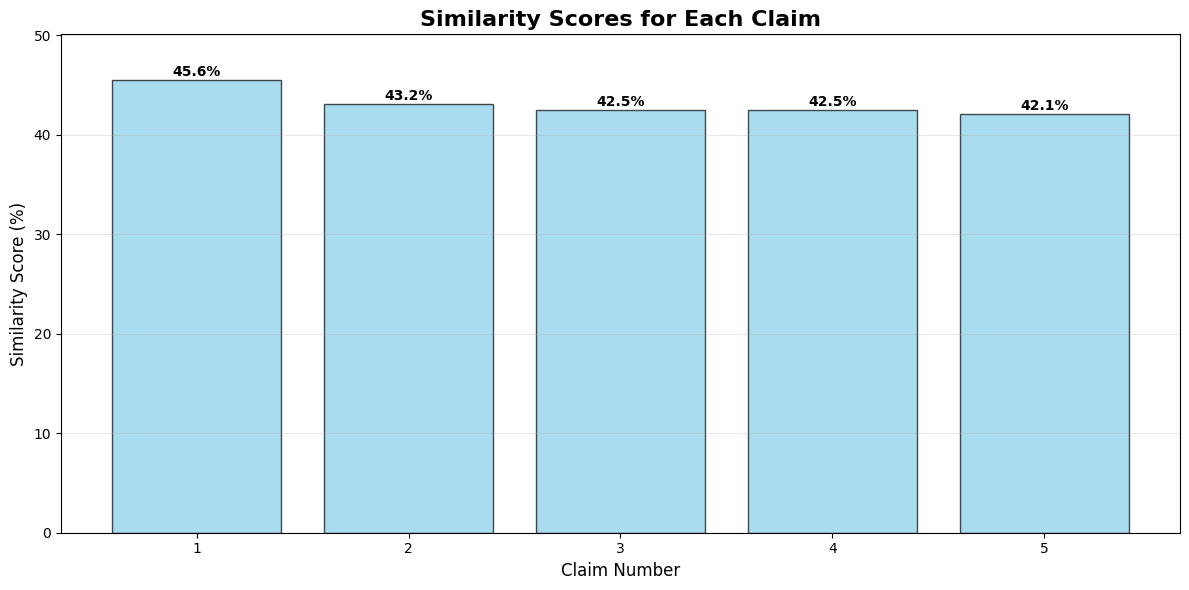


📊 Similarity Scores Summary:
Claim 1: 45.56%
  Getting the first dose of Covid-19 vaccine increases risk of...
  Rating: b'Misleading'

Claim 2: 43.15%
  People vaccinated against Covid-19 pose a health risk to oth...
  Rating: b'False'

Claim 3: 42.53%
  Vaccinated people are 885% more likely to die of Covid-19 th...
  Rating: b'False'

Claim 4: 42.51%
  In the United Kingdom, 70-plus percent of the people who die...
  Rating: FALSE

Claim 5: 42.13%
  Only the fully vaccinated should fear the new ‘worst ever’ C...
  Rating: FALSE

📈 Statistics:
  Highest score: 45.56%
  Lowest score:  42.13%
  Average score: 43.17%
  Range:         3.43%


In [29]:
# Simple bar chart showing each individual similarity score

import matplotlib.pyplot as plt
import pandas as pd

if results_df is not None and 'similarity' in results_df.columns:
    # Convert similarity to numeric
    results_df['similarity'] = pd.to_numeric(results_df['similarity'], errors='coerce')
    
    # Create a simple bar chart
    plt.figure(figsize=(12, 6))
    
    # Create bars for each claim
    claim_numbers = range(1, len(results_df) + 1)
    bars = plt.bar(claim_numbers, results_df['similarity'], 
                   color='skyblue', edgecolor='black', alpha=0.7)
    
    # Customize the chart
    plt.title("Similarity Scores for Each Claim", fontsize=16, fontweight='bold')
    plt.xlabel("Claim Number", fontsize=12)
    plt.ylabel("Similarity Score (%)", fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Set x-axis ticks
    plt.xticks(claim_numbers)
    
    # Add some padding to y-axis
    plt.ylim(0, max(results_df['similarity']) * 1.1)
    
    plt.tight_layout()
    plt.show()
    
    # Show the data in a clean table format
    print("\n📊 Similarity Scores Summary:")
    print("="*50)
    for i, row in results_df.iterrows():
        print(f"Claim {i+1}: {row['similarity']:.2f}%")
        print(f"  {row['vclaim'][:60]}...")
        print(f"  Rating: {row['rating']}")
        print()
    
    # Show basic statistics
    print("📈 Statistics:")
    print(f"  Highest score: {results_df['similarity'].max():.2f}%")
    print(f"  Lowest score:  {results_df['similarity'].min():.2f}%")
    print(f"  Average score: {results_df['similarity'].mean():.2f}%")
    print(f"  Range:         {results_df['similarity'].max() - results_df['similarity'].min():.2f}%")

else:
    print("❌ results_df is not loaded or doesn't have 'similarity' column.")
    if results_df is not None:
        print("Available columns:", results_df.columns.tolist())